# Product Clustering : a geographical analysis
In this notebook answer the following questions:

1. Are similar areas in terms of typical products geographically close?
2. Can we naturally cluster areas geographically when it comes to food consumption in London?
3. How do those clusters differ when we vary the aggregation level?
4. In the context of an advertising campaign, which areas of the city should be associated with which kind of products?

Before answering those questions we will first visualise our dataset to understand if we could even hope to be able to demonstrate such a relationishp between product and geography.

# Interactive visualization
## Data Loading
### Statistical GIS Boundary Files dataset
In the section, we will use ```geopandas``` to load the [Statistical GIS Boundary Files for London](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london). Even if this dataset was made avialable in 2011, we should note that the boundaries haven't really changed compared to 2015 (date of Tesco Dataset) and it should not impact our visualisation.

For each aggregation level ```LSOA```, ```MSOA```, ```WARD```, ```BOROUGH``` we read the correponding file and retreive the following subset of columns: 

* ```area_id ```: the id of the area considered
* ```name    ```: the name of the area considered
* ```geometry```: the geometric shape of the area in the 2D london map (polygon or multipolygon if the area is definied in multiple pieces)

We then store the resulting geopandas dataframe into a dictionary for later usage.

In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np
#data path
data_path = 'data/'
geo_path  = data_path + 'statistical-gis-boundaries-london/ESRI2/'
#read geopandas df and selected subset of columns
gdf_lsoa = gpd.read_file(geo_path + 'LSOA_2011_London_gen_MHW.shp' )[['LSOA11CD','LSOA11NM','geometry']]\
            .rename(columns={'LSOA11CD':'area_id','LSOA11NM':'name'})
gdf_msoa = gpd.read_file(geo_path + 'MSOA_2011_London_gen_MHW.shp' )[['MSOA11CD','MSOA11NM','geometry']]\
            .rename(columns={'MSOA11CD':'area_id','MSOA11NM':'name'})
gdf_ward = gpd.read_file(geo_path + 'London_Ward_CityMerged.shp')[['GSS_CODE','NAME','geometry']]\
            .rename(columns={'GSS_CODE':'area_id','NAME':'name'})
gdf_borough = gpd.read_file(geo_path + 'London_Borough_Excluding_MHW.shp' )[['GSS_CODE','NAME','geometry']]\
            .rename(columns={'GSS_CODE':'area_id','NAME':'name'})
#store them into a dictionary
gdf = {'lsoa':gdf_lsoa,'msoa':gdf_msoa,'osward':gdf_ward,'borough':gdf_borough}
gdf_lsoa.head()

,area_id,name,geometry
0,E01000001,City of London 001A,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18..."


### Tesco data set

We can proceed further by reading the tesco dataset (output of ```cluster.jpnb```). This dataset contains a subset of the orginal tesco dataset containing some of typical product features:

> ```fat,saturate,sugar,protein,carb,fibre,energy_tot,h_nutriments_calories```

Moreover, it stores these features for each combinaison of 

 * ```aggretation level``` : lsoa, msoa, ward, borough 
 * ```period```            : January, February,..., December as well as the yearly aggregation (Year)

The following cell aims at constructing a efficient indexing data structure that allows to easily retrieve the typical product for a given aggregation level and period in order to speed up the refreshing time of the visualization. We used a dictionary for this purpose.

In [42]:
tesco = pd.read_csv('data/tesco.csv')
tesco.head()

,area_id,fat,saturate,sugar,protein,carb,fibre,energy_tot,h_nutrients_calories,month,agg_level
0,E09000001,8.472985,3.361599,9.278065,5.253333,15.779639,1.619850,165.851751,1.618208,yea,borough
1,E09000002,9.209959,3.596834,10.793244,5.193872,19.784988,1.590335,187.174390,1.545272,yea,borough
2,E09000003,8.594464,3.407353,9.530548,5.129627,17.025950,1.638639,170.655504,1.581507,yea,borough
3,E09000004,9.119180,3.466346,10.941085,5.304496,19.997105,1.657118,187.754791,1.551703,yea,borough
4,E09000005,8.962466,3.559913,10.148610,5.132915,18.726476,1.585978,180.510586,1.555736,yea,borough


In [5]:
periods          = list(tesco.month.unique())
agg_levels       = list(tesco.agg_level.unique())
feature_names    = [c for c in tesco.columns if c not in ['area_id','month','agg_level']]

tesco_dict = dict()
for level in agg_levels:
    inner = dict()
    for mo in periods:
        df_mo_level = tesco.query("agg_level == @level and month == @mo")
        inner[mo]   = gdf[level].merge(df_mo_level, on='area_id', how = 'left').fillna('No data')
    tesco_dict[level] = inner

### Convert data into JSON format for Bokeh

The bokeh library we are going to use to make the interactive visualiastion requires the data to be encoded in a JSON format. Given a ```agg_level``` and a ```month``` the following function will performs this encoding.

In [6]:
import json
#Convert data to json
def json_data(agg_level,month,feature=None):
    mo = tesco_dict[agg_level][month]
    merged_json = json.loads(mo.to_json())
    json_data = json.dumps(merged_json)
    return json_data

## Visualisation creation

Since we want to create an interactive visualisation need to store the current state of the application. We chose to simply record in a dict name ```state```:

1. ```agg_level```: the aggregation level 
2. ```feature  ```: the feature of the typical product (or custering) that 
3. ```month    ```: Jan, Feb,..., Dec as well as the yearly aggregation (Year)

### Color Bar helper functions
In this first section we will define several helper functions that will be used by the visualisation in the last cells of this notebook. We will focus in creating a ```color bar``` for the visualisation. It should obsivously depend on the feature (will define de range of the color bar).

In [ ]:
def get_feature(state:dict):
    """
    Returns the pd.Series associated to state where the missing values are 
    filtered and the type is converted from string to double
    """
    #get the data from the aggregation
    data = tesco_dict[state['agg_level']][state['month']][state['feature']]
    data = data[data != 'No data']  # filter missing values
    data = data.astype(np.double)   # convert into double
    out  = data if len(data)>0 else None
    return out

def create_color_mapper(state:dict,n_default_colors=8,nan_color='#d9d9d9'):
    """
    This function create the color mapper used in the colorbar for the given state
    """
    feature  = get_feature(state)                    # Select feature
    if state['feature'].startswith('cluster'):
        n_colors = max(feature.nunique(),3) if feature is not None else 1
        palette  = Category10[max(n_colors,3)][:n_colors]
    else:
        n_colors = n_default_colors
        palette  = brewer['YlGnBu'][n_colors]           # Reverse : dark blue is for highest values.
        palette  = palette[::-1]                        # Create a linear color mapper with right range
    low  = 0 if feature is None else feature.min()
    high = 1 if feature is None else feature.max()
    color_mapper = LinearColorMapper(
            palette = palette, nan_color = nan_color,   # nan color
            low = low, high = high)                     # right range
    return color_mapper

def create_color_bar(state:dict,plot,geosource):
    """
    Creates the color bar given the state and geosource and link it to the plot
    """
    color_mapper = create_color_mapper(state)       # use previous function to create the mapper
    color_bar = ColorBar(color_mapper=color_mapper, # set the mapper
        label_standoff=8,width = 500, height = 20,  # specify size 
        border_line_color=None,                     # style : no border lines
        location = (0,0), orientation ='horizontal')# horizontal bar 
    # link color bar and plot 
    plot.patches('xs','ys', source = geosource,     # link geosource
        fill_color = {'field' :state['feature'],    # color related to selected feature
                      'transform':color_mapper},    # use the defined colormapper
        line_color = 'black',                       # style : black borders
        line_width = 0.25, fill_alpha = 1)          # more styling
    plot.add_layout(color_bar, 'below')             # add color bar below plot
    return color_bar

### Handling events : user clicks and changes
The following method will handle the interactivity in our plot. When the user select a new ```month```, ```agg_level``` or ```feature```, we need to update:

1. The title of the plot
2. The color mapper of the plot since the range of value has changed. We chose to only update it when we change the feature. In that way it is still possible to compare the results accross months
3. the hover 

In [ ]:
def update_plot(state_field:str, new_val:str,state:dict,plot,geosource,color_bar):
    """
    Handles interactivity in the visualization
    @param state_field : (str) element of the state that needs to be updated
    @param new_val     : (str) new value of state_field element 
    """
    state[state_field] = new_val  # state update
    # update title
    plot.title.text = "{feature} consumption for {agg_level} during the prediod {month}".format(**state)
    if state_field == 'feature':                    # update color mapper
        color_mapper = create_color_mapper(state)   # create new mapper
        color_bar.color_mapper = color_mapper       # set the new mapper in color bar
        plot.patches('xs','ys',                     # update patches
            source = geosource,
            fill_color = {'field' :state['feature'], 'transform' : color_mapper},
            line_color = 'black', line_width = 0.25, fill_alpha = 1)
    new_data = json_data(**state)                   # get the new data and convert to JSON
    geosource.geojson = new_data                    # set new data to trigger recoloring event
    # new hover for the new feature 
    hover = HoverTool(tooltips = [('Area name','@name'),(state['feature'], '@'+state['feature'])])
    # add hover tools to plot
    plot.tools = [hover]

### Creation of the actual figure and components
Here is are the actual components defined. We created a ```bkapp``` (bokeh application) function that given the ```doc``` (bokeh document), creates the components :

1. ```plot          ```: map of colors for the selected areas
2. ```btn_period    ```: button to select the period
3. ```btn_agg_level ```: button to select the aggregaton level
4. ```select_feature```: button to select the feature of typical product to display (or clustering)

it then adds the respective event handers and links the components to the ```doc```

In [ ]:
import yaml
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Slider,HoverTool
from bokeh.plotting import figure
from bokeh.themes import Theme
from bokeh.io import show, output_notebook
from bokeh.models.widgets import Button, RadioButtonGroup, Select, Slider
from bokeh.sampledata.sea_surface_temperature import sea_surface_temperature
from bokeh.io import output_notebook, show, output_file,save
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar,CategoricalColorMapper
from bokeh.palettes import brewer,Category10
from bokeh.resources import CDN
from bokeh.embed import file_html

# output notebook to allow inline jupyter interaction
output_notebook()

def bkapp(doc):
    # default state when the component is loaded for the first time
    state = {'month':'yea','agg_level':'borough','feature':'fat'}
    geosource = GeoJSONDataSource(geojson = json_data(**state))
    # Hover that will show the current feature value for the hovered area + its name
    hover = HoverTool(tooltips = [ ('Area name','@name'),(state['feature'], '@'+state['feature'])])
    # Create figure for the plot
    plot = figure(title = 'Fibre consumption during period', 
            plot_height = 800 , plot_width = 950, toolbar_location = None,
            tools = [hover])
    # Remover axis for nicer layout
    plot.xgrid.grid_line_color = None
    plot.ygrid.grid_line_color = None
    plot.axis.visible = False
    # Add the color bar
    color_bar = create_color_bar(state,plot,geosource)    
    #create graphical components for the user to interact
    btn_period     = RadioButtonGroup(labels=periods, active=0)       # selection aggregation level
    btn_agg_level  = RadioButtonGroup(labels=agg_levels, active=0)    # selection aggregation level
    select_feature = Select(title="Typical product feature:", 
                            value=feature_names[0], options=feature_names)
    #add event handler
    local_update_plot = lambda st,v: update_plot(st, v,state,plot,geosource,color_bar)
    btn_period.on_click(              lambda new         : local_update_plot('month'    ,periods[new]))
    btn_agg_level.on_click(           lambda new         : local_update_plot('agg_level',agg_levels[new]))
    select_feature.on_change('value', lambda attr,old,new: local_update_plot('feature'  ,new))
    #add components to root document
    doc.add_root(column(btn_period,btn_agg_level, plot,select_feature))
    #output_file('images/vizu.html')
    #save(doc,filename='images/vizu.html')

In [ ]:
# show the viz in jupyter but otherwise : notebook_url="http://localhost:8888"
show(bkapp)

After playing a bit with the visualisation, we can easily convice ourselves that we can indeed recognize some dependencies between typical product features and the geographical localisation of the areas. 
...................

...................

TO DO 

...................

...................

...................

...................

...................

# (a) Clustering Analysis

We will start by studing the ouput clustering of a K-means algorithm to undertand which values of $k$ will produce the most natural clustering __*in the typical product space*__. We will then try to make some sense of out this clustering by performing a vizualization in 2D using several dimentionality reduction techniques. We might hope that we will already be able to see some geographical structure in those plots (recognize somehow the map of London). If not we will have to apply other techniques to help access the geographical validation of the clusters, if any.

## Naive Analysis
In this naive Analysis will not take into account the geographical aspect of the dataset. Since we only want to get a feeling about how k-means performs with the ```tesco`` data, we will select a subset of the dataset for this analysis. To be as precise as possible we study the smallest aggregation level for the entire year period.

In [11]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
%matplotlib inline

# select subset of tesco data set
sub_tesco = tesco.query('month=="yea" and agg_level=="lsoa"')\
            .drop(columns=['month','agg_level'])
sub_tesco = sub_tesco.set_index('area_id')
sub_tesco.head()

,fat,saturate,sugar,protein,carb,fibre,energy_tot,h_nutrients_calories
area_id,,,,,,,,
E01000001,8.535149,3.498749,9.213734,5.262429,15.158014,1.622653,163.985327,1.620439
E01000002,8.054729,3.159077,8.337412,5.351774,14.358466,1.692822,157.572172,1.661276
E01000003,8.153757,3.375788,9.414937,5.029519,15.820254,1.522523,163.321285,1.646243
E01000005,8.339058,3.319496,9.603258,5.230254,17.126487,1.612862,169.339310,1.595496
E01000006,9.622101,3.864007,11.355115,5.026295,19.903063,1.640227,190.310015,1.519193


### Standard K-means analysis : silhouette and sse
The followings cells aim at choosing which value of ```k``` leads to a good clustering assignment. The standard procedure for doing so, is to look at the ```silhouette``` and ```sse``` plots.  

In [17]:
silhouettes = []
for k in range(2, 11): # Try multiple k
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(sub_tesco)
    # Get the Silhouette score
    score = silhouette_score(sub_tesco, labels)
    silhouettes.append({"k": k, "score": score})
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)
sse = []
for k in range(1, 10):
    # Assign the labels to the clusters
    kmeans = KMeans(n_clusters=k, random_state=10).fit(sub_tesco)
    sse.append({"k": k, "sse": kmeans.inertia_})
sse = pd.DataFrame(sse)

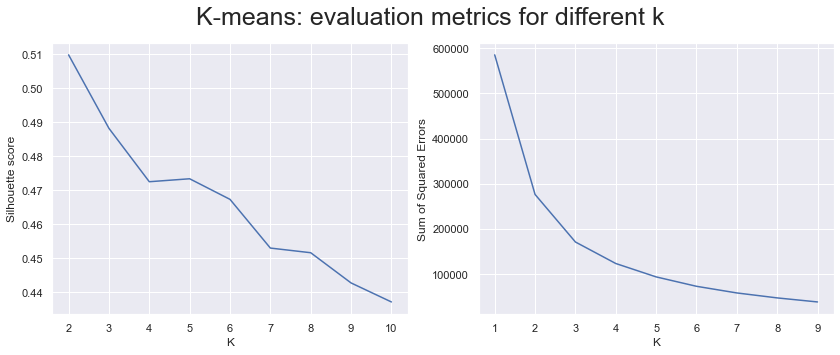

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(14,5))
# Plot silhouettes
plt.subplot(121)
sns.lineplot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
# Plot sse
plt.subplot(122)
sns.lineplot(sse.k, sse.sse)
plt.xlabel("K")
plt.ylabel("Sum of Squared Errors")
fig.suptitle("K-means: evaluation metrics for different k",fontsize=25)
plt.show()

The elbow method seems to indicate that 2,4 and 7 might be revelant as choices of ```k``` for this dataset.

................................................

................................................

................................................

................................................

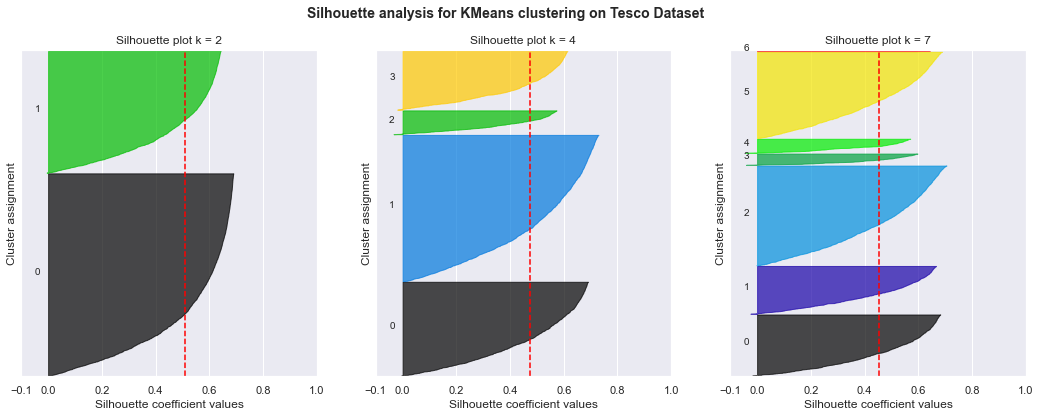

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

n_clusters_range = [2,4,7]
fig, axs = plt.subplots(1, len(n_clusters_range))
fig.set_size_inches(18, 6)
for j,k in enumerate(n_clusters_range):
    ax = axs[j]
    ax.set_xlim([-0.1, 1]) # silhouette lie within [-0.1, 1] here
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(sub_tesco) + (k + 1) * 10])
    # Do the clustering 
    clusterer = KMeans(n_clusters=k, random_state=10)
    labels = clusterer.fit_predict(sub_tesco)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(sub_tesco, labels)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(sub_tesco, labels)
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("Silhouette plot k = %d" %k)
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster assignment")
    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    
plt.suptitle(("Silhouette analysis for KMeans clustering on Tesco Dataset "),
                 fontsize=14, fontweight='bold')
plt.show()

Silhouette scores can be interpreted as follows :
 * 1  indicate that the sample is far away from the neighboring clusters
 * 0  indicates that the sample is on or very close to the decision boundary between two neighboring clusters
 * <0 indicate that those samples might have been assigned to the wrong cluster. 

Only for ```k = 7```, we observe high variability scores (inside clusters) which indicates that the clustering might not be so good. Howeve, for all k, we do not have presence of clusters with below average silhouette scores which is a good point.

### K-means 2D visualisation

#### Dimensionality Reduction : PCA and TNSE

In the previous point, we tried to formaly understand the goodness of fit for the clusters found. Here, we will take a more visual approach and we will use dimensionality reduction techniques to plot the dataset in 2D.

In [36]:
sub_tesco_pca  = PCA(n_components=2).fit(sub_tesco).transform(sub_tesco)
sub_tesco_tsne = TSNE(n_components=2, random_state=0).fit_transform(sub_tesco)

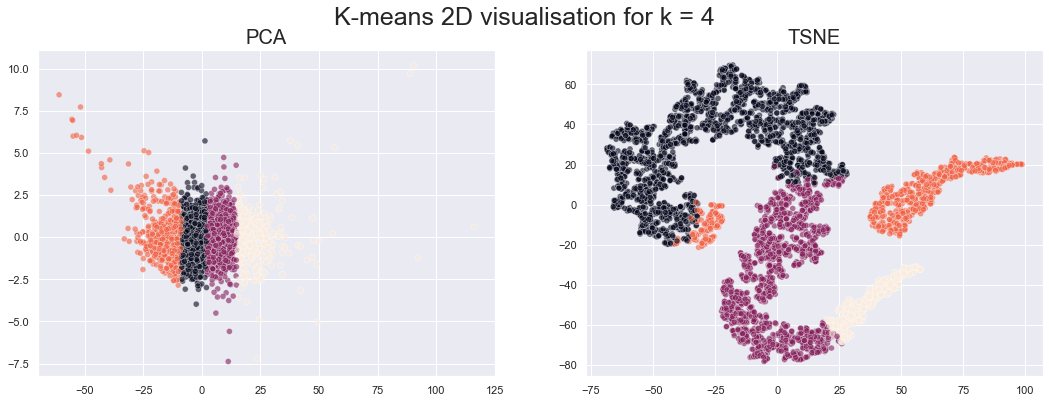

In [37]:
k = 4 #let's choose k=4 arbitrarely 
fig, axs = plt.subplots(2, 1, figsize=(18,6))
labels = KMeans(n_clusters=k, random_state=42).fit_predict(sub_tesco)
plt.subplot(121)
ax = sns.scatterplot(sub_tesco_pca[:,0], sub_tesco_pca[:,1], c=labels, alpha=0.6)
ax.set_title("PCA",fontsize=20)
plt.subplot(122)
ax = sns.scatterplot(sub_tesco_tsne[:,0], sub_tesco_tsne[:,1], c=labels, alpha=0.6)
ax.set_title("TSNE",fontsize=20)
fig.suptitle("K-means 2D visualisation for k = %d" % k,fontsize=25)
plt.show()

Here we understand that k = 2 might be better choice if we think of TSNE. 

If we go back to our initial question, we tried to undertand if there was a relationship between similar typical product and simalar areas (geographical areas). At the begining of this notebook, we though that we might be able to recognize London from those simple dimentionality reduction 2D plots but this is clearly not the case. This does not mean that the previously mentioned relationship does not existis, it simply we have to think more carefuly about how we are going to address the question.

## Geographical Clustering plot

In the previous cells we failed to show the presence of a geographical relationship between products and area. We will try this again but this time, we will use our interactive visualisation to plot the clusters. This visualisation will allow to select a ```k``` in the set```[1,2,...,8]``` and see the resulting clusters.

### Creation of DataFrame of clusters
We will create a new dataframe ```tesco_year``` that contains only the data for the complete year. In addition, we will add the clustering assignments all the previously defined ```k```

In [43]:
tesco_year = tesco.query("month == 'yea'")
max_k = 8
for k in range(2,max_k+1):
    new_col_name='cluster_'+str(k)
    tesco_year[new_col_name]='No data'

In [44]:
for lvl in agg_levels:
    tesco_lvl = tesco_year[tesco_year.agg_level == lvl]
    for k in range(2,max_k+1):
        labels = KMeans(n_clusters=k, random_state=42).fit_predict(tesco_lvl[feature_names])
        tesco_year.loc[tesco_lvl.index,'cluster_'+str(k)] = labels
#tesco.to_csv('data/tesco_cluster.csv',index=False)
tesco_year.head(5)

,area_id,fat,saturate,sugar,protein,carb,fibre,energy_tot,h_nutrients_calories,month,agg_level,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,E09000001,8.472985,3.361599,9.278065,5.253333,15.779639,1.619850,165.851751,1.618208,yea,borough,1,0,3,1,5,5,5
1,E09000002,9.209959,3.596834,10.793244,5.193872,19.784988,1.590335,187.174390,1.545272,yea,borough,0,1,1,2,4,1,1
2,E09000003,8.594464,3.407353,9.530548,5.129627,17.025950,1.638639,170.655504,1.581507,yea,borough,1,0,3,3,2,3,3
3,E09000004,9.119180,3.466346,10.941085,5.304496,19.997105,1.657118,187.754791,1.551703,yea,borough,0,1,1,2,4,1,1
4,E09000005,8.962466,3.559913,10.148610,5.132915,18.726476,1.585978,180.510586,1.555736,yea,borough,0,2,2,0,3,2,2


### Interactive Clustering visualisation
.............................................

.............................................

.............................................

.............................................

.............................................

.............................................

.............................................

.............................................

In [ ]:
#============================
#============================
#========= TO DO ============
#============================
#============================

DO THE ANALYSIS

.............................................

.............................................

.............................................

.............................................

.............................................

.............................................

.............................................

.............................................

## Formal Geographical Validation

In this section, we are going to 

In [14]:
data_path = 'data/statistical-gis-boundaries-london/ESRI2/'
gdf_lsoa = gpd.read_file(data_path + 'LSOA_2011_London_gen_MHW.shp' )[['LSOA11CD','geometry']]\
                .rename(columns={'LSOA11CD':'area_id'})
gdf_lsoa = gdf_lsoa.reset_index()
gdf = add_clusters(gdf_lsoa)
gdf.head(2)

,level_0,index,area_id,geometry,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_random_2,cluster_random_3,cluster_random_4,cluster_random_5,cluster_random_6,cluster_random_7,cluster_random_8
0,2,0,E01000001,"POLYGON ((532105.092 182011.230, 532162.491 18...",0,2,2,2,5,2,2,0,0,0,0,1,4,7
1,15,1,E01000002,"POLYGON ((532746.813 181786.891, 532671.688 18...",0,2,2,2,5,2,2,0,2,0,3,5,5,2
2,28,2,E01000003,"POLYGON ((532135.145 182198.119, 532158.250 18...",0,2,2,2,5,2,2,1,0,3,4,2,5,5
3,41,3,E01000005,"POLYGON ((533807.946 180767.770, 533649.063 18...",0,2,2,4,2,5,0,0,1,1,1,3,6,5


In [13]:
def add_clusters(gdf):
    cols = [c for c in df.columns if c.startswith("cluster")]
    out = gdf.merge(df[['area_id']+cols],on='area_id',how='inner').query("cluster_2 != 'No data'")
    out[cols] = out[cols].astype('int')
    out = out.reset_index()
    for k in range(2,max_k +1):
        out['cluster_random_'+str(k)] = np.random.randint(k, size=len(out))
    return out

## Geographical Silhouette

In [25]:
geo_coords  = gdf_lsoa.geometry.centroid.apply(lambda p: pd.Series({'x':p.x,'y':p.y}))
geo_coords['area_id'] = gdf_lsoa.area_id
geo_coords  = geo_coords.merge(data,on='area_id',how='inner')[['x','y']]
silhouettes = []
# Try multiple k
for k in range(2, 20):
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(data)
    # Get the Silhouette score
    geo_score  = silhouette_score(geo_coords, labels)
    silhouettes.append({"k": k, "geo_score": geo_score, "Clustering Type":"k-means"})
    #random graph comparison
    rnd_score = silhouette_score(geo_coords, np.random.randint(k, size=len(labels)))
    silhouettes.append({"k": k, "geo_score": rnd_score, "Clustering Type":"random"})
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)
silhouettes.head(3)

,k,geo_score,Clustering Type
0,2,0.102800,k-means
1,2,-0.000110,random
2,3,-0.028515,k-means


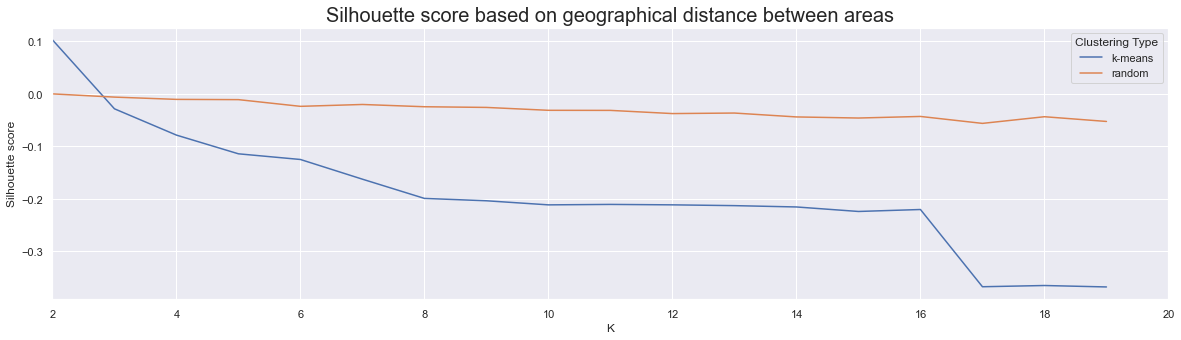

In [26]:
plt.figure(figsize=(20,5))
# Plot the data
ax = sns.lineplot(data=silhouettes, x='k', y='geo_score', hue="Clustering Type")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
ax.set_xlim((2,20))
plt.title("Silhouette score based on geographical distance between areas",fontsize=20)
plt.show()

## Border Scores

In [20]:
def add_neighbors_clusters(gdf):
    cols = [c for c in gdf.columns if c.startswith("cluster")]
    l = [None] *len(gdf)
    for idx, row in tqdm(gdf.iterrows(), total=len(gdf.index)):
        neighbors = gdf[~gdf.geometry.disjoint(row.geometry)][['area_id']+cols]\
            .query("area_id != '"+str(row.area_id)+"'")[cols]
        l[idx] = np.sum(neighbors == row[cols])
    
    tmp = pd.concat(l,axis=1).T.rename(
        columns={c:'cluster_border_neighbors_'+("random_" if c.find('random')!=-1 else "")+c[-1] 
                 for c in cols})
    return pd.concat((gdf,tmp),axis=1)

In [21]:
neighbors = add_neighbors_clusters(gdf)

100%|██████████| 4833/4833 [01:53<00:00, 42.60it/s]


In [22]:
def create_border_scores(gdf):
    l = []
    for k in range(2,max_k+1):
        # mean border scores
        col       = "cluster_"+str(k)
        score_col = "cluster_border_neighbors_" + str(k)
        sdf = gdf.groupby(col)[score_col].mean()\
            .drop(columns=['index'])\
            .rename('mean_border_score_'+str(k))
        # random assignment
        random_col       = 'cluster_random_'+str(k)
        random_score_col = "cluster_border_neighbors_random_" + str(k)
        random_mean      = gdf.groupby(random_col)[random_score_col]\
                                .mean()\
                                .mean()
        #create output pd series
        l.append(sdf.append(pd.Series({'random':random_mean})))
    out = pd.concat(l,axis=1)
    out = out.rename(columns={c:"cluster_"+str(int(c)+2) for c in out.columns})
    out.index = out.index.astype(str)
    return out.sort_index()

In [23]:
mean_borders = create_border_scores(neighbors)
mean_borders.to_csv('data/mean_border_score.csv',index=False)
mean_borders

,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,4.283726,3.545064,3.275125,2.734783,2.568956,2.360133,2.444638
1,3.388767,2.537017,2.526681,0.821429,1.398964,2.008264,1.797557
2,NaN,3.139927,2.730583,2.157480,2.683307,1.980769,2.089005
3,NaN,NaN,1.302452,2.278826,0.000000,2.179195,1.815962
4,NaN,NaN,NaN,2.840268,2.043400,0.000000,0.866242
5,NaN,NaN,NaN,NaN,2.129450,2.235294,2.280161
6,NaN,NaN,NaN,NaN,NaN,0.906977,0.000000
7,NaN,NaN,NaN,NaN,NaN,NaN,2.153846
random,2.795813,1.851411,1.400247,1.106636,0.927410,0.768110,0.667628


##  Visualisation

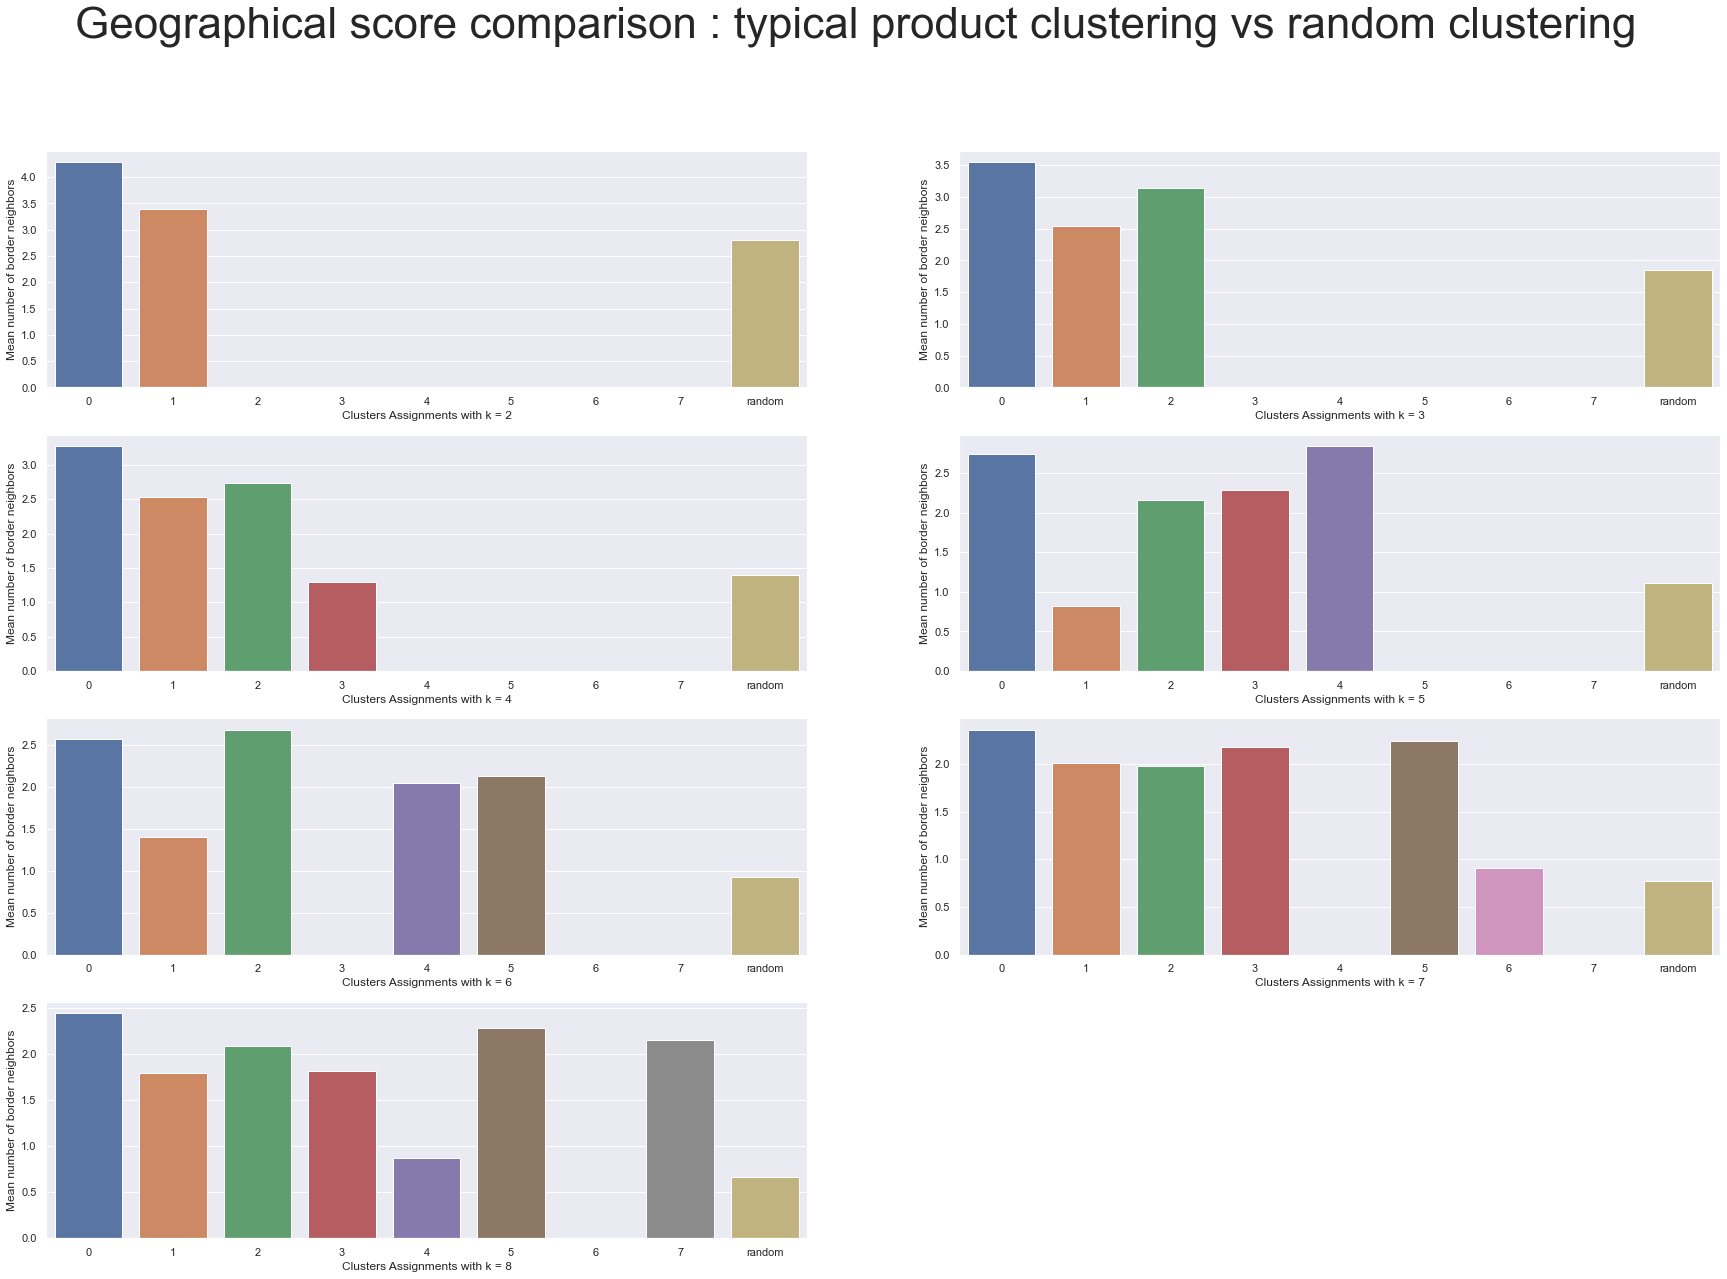

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(30,20))
for i in range(1,8):
    plt.subplot(4,2,i)
    ax = sns.barplot(x = mean_borders.index, y="cluster_"+str(i+1),data=mean_borders)
    ax.set_xlabel("Clusters Assignments with k = "+str(i+1))
    ax.set_ylabel("Mean number of border neighbors")
    #g.add_legend()
fig.suptitle("Geographical score comparison : typical product clustering vs random clustering", fontsize=44)
plt.show()

# Graph analysis

We will now try a different approach to evaluate our clustering. We will create a graph where each area is a node, and there's an edge between every adjacent areas (areas with a common border). Then we will compute the shortest path length for every pair of nodes, and use it as a distance metric for a new silhouette analysis.

First, we load the data.

In [39]:
df=pd.read_csv('data/tesco_cluster.csv')
df_lsoa = df.query('agg_level == "lsoa"').query('month == "yea"')
df_lsoa.head()

,area_id,fat,saturate,sugar,protein,carb,fibre,energy_tot,h_nutrients_calories,month,agg_level,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
13718,E01000001,8.535149,3.498749,9.213734,5.262429,15.158014,1.622653,163.985327,1.620439,yea,lsoa,0,2,2,2,5,2,2
13719,E01000002,8.054729,3.159077,8.337412,5.351774,14.358466,1.692822,157.572172,1.661276,yea,lsoa,0,2,2,2,5,2,2
13720,E01000003,8.153757,3.375788,9.414937,5.029519,15.820254,1.522523,163.321285,1.646243,yea,lsoa,0,2,2,2,5,2,2
13721,E01000005,8.339058,3.319496,9.603258,5.230254,17.126487,1.612862,169.339310,1.595496,yea,lsoa,0,2,2,4,2,5,0
13722,E01000006,9.622101,3.864007,11.355115,5.026295,19.903063,1.640227,190.310015,1.519193,yea,lsoa,1,1,1,3,4,1,1


Then we compute the list of neighbors for every area, and store it in the dataframe.

In [40]:
def add_neighbors_list(gdf):
    """
    Compute the list of neighboring areas for every area in the given dataframe, and store it in the dataframe
    @gdf : Geopandas dataframe that contains every areas and their geometrical information in a column named 'geometry'
    return : augmented dataframe
    """
    l = []
    for idx, row in tqdm(gdf.iterrows(), total=len(gdf.index)):
        neighbors = gdf[~gdf.geometry.disjoint(row.geometry)][['area_id']]\
            .query("area_id != '"+str(row.area_id)+"'").area_id.values
        l.append(neighbors)
    gdf["border_neighbors"] = l
    return gdf

In [29]:
gdf_lsoa_neighbors = add_neighbors_list(gdf_lsoa.merge(df_lsoa['area_id'], how='inner', on='area_id'))

100%|██████████| 4833/4833 [01:37<00:00, 49.34it/s]


In [41]:
# Keep only columns of interest for the graph
gdf_lsoa_edges = gdf_lsoa_neighbors[['area_id', 'border_neighbors']]
gdf_lsoa_edges.head()

,area_id,border_neighbors
0,E01000001,"[E01000002, E01000003, E01032739, E01032740, E..."
1,E01000002,"[E01000001, E01000003, E01002704, E01032739]"
2,E01000003,"[E01000001, E01000002, E01002704, E01002706, E..."
3,E01000005,"[E01004293, E01004294, E01004310, E01032739, E..."
4,E01000006,"[E01000009, E01000044, E01000068, E01000071]"


In [31]:
# Flatten the lists to put the dataframe in a networkx-friendly form
edges = pd.DataFrame([[gdf_lsoa_edges.area_id[i], x] 
               for i, y in gdf_lsoa_edges['border_neighbors'].iteritems() 
                    for x in y], columns=['area_id', 'neighbor'])
edges.head()

,area_id,neighbor
0,E01000001,E01000002
1,E01000001,E01000003
2,E01000001,E01032739
3,E01000001,E01032740
4,E01000001,E01033490


We can now create the graph and compute the pairwise shortest path lengths.

In [42]:
import networkx as nx

# Create graph from edge list, using columns area_id annd neighbor
G = nx.from_pandas_edgelist(edges, 'area_id', 'neighbor')

# Compute shortest path length for every pair of nodes in the graph
shortest_path_len = dict(nx.shortest_path_length(G))

# Put it in a matrix
distance_matrix = pd.DataFrame(shortest_path_len)

# Sort the rows and columns so that they are in the same order (i.e there are zeros in the diagonal)
distance_matrix = distance_matrix[df_lsoa['area_id']].sort_index()
distance_matrix.head()

,E01000001,E01000002,E01000003,E01000005,E01000006,E01000007,E01000008,E01000009,E01000010,E01000011,...,E01033737,E01033738,E01033739,E01033740,E01033741,E01033742,E01033743,E01033744,E01033745,E01033746
E01000001,0,1,1,2,22,21,20,21,20,22,...,25,20,29,28,29,27,29,27,30,17
E01000002,1,0,1,2,22,21,20,21,20,22,...,25,20,29,28,29,27,29,27,30,17
E01000003,1,1,0,3,23,22,21,22,21,22,...,26,21,30,29,30,28,30,28,31,18
E01000005,2,2,3,0,21,20,19,20,19,21,...,25,20,29,28,29,27,29,27,30,17
E01000006,22,22,23,21,0,2,3,1,2,2,...,45,40,49,48,49,47,49,47,50,37


Having this matrix, we can now calculate the silhouette score of the K-means clustering using our new metric.

In [38]:
score = silhouette_score(X=distance_matrix.astype(float), labels=df_lsoa['cluster_2'], metric="precomputed")
score

0.0727654496701839

# Changer en dessous !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [44]:
silhouettes = []
for k in range(2, 9):
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(data)
    # Get the Silhouette score
    graph_score  = silhouette_score(X=distance_matrix.astype(float), labels=df_lsoa['cluster_'+str(k)], metric="precomputed")
    silhouettes.append({"k": k, "graph_score": graph_score, "Clustering Type":"k-means"})
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)
silhouettes.head(3)

,k,graph_score,Clustering Type
0,2,0.072765,k-means
1,3,-0.019171,k-means
2,4,-0.058361,k-means


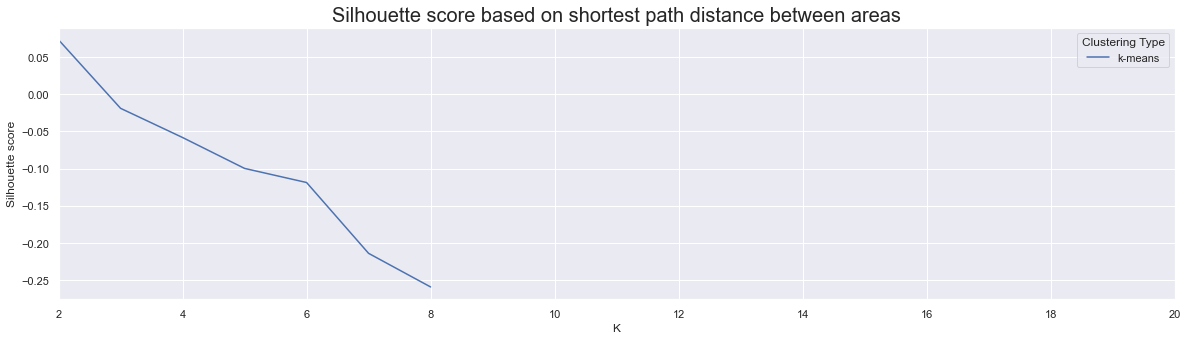

In [45]:
plt.figure(figsize=(20,5))
# Plot the data
ax = sns.lineplot(data=silhouettes, x='k', y='graph_score', hue="Clustering Type")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
ax.set_xlim((2,20))
plt.title("Silhouette score based on shortest path distance between areas",fontsize=20)
plt.show()